### Launch EVA DB
Run the command `eva_server` in the server where you want to deploy EVA

### Establish Connection With Eva DB

In [1]:
import sys
sys.path.insert(0,'..')
from eva.server.db_api import connect

In [3]:
import nest_asyncio
nest_asyncio.apply()
connection = connect(host = '0.0.0.0', port = 5432) # hostname, port of the server where EVADB is running

In [4]:
cursor = connection.cursor()

### Upload the survellience video to analyse

In [5]:
cursor.execute('UPLOAD INFILE "../data/mnist/mnist.mp4" INTO MNISTVideo;')
response = cursor.fetch_all()

### Visualize Video

In [6]:
from IPython.display import Video
Video("../data/mnist/mnist.mp4", embed=True)

In [7]:
cursor.execute("""CREATE UDF IF NOT EXISTS MnistCNN
                  INPUT  (data NDARRAY (3, 28, 28))
                  OUTPUT (label TEXT(2))
                  TYPE  Classification
                  IMPL  'tutorials/apps/mnist/eva_mnist_udf.py';
        """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                              0
0  UDF MnistCNN already exists, nothing added.
@batch_size: 1
@identifier_column: None
@query_time: 0.007658132000017304


### Run Object detector on the video

In [9]:
cursor.execute("""SELECT data, MnistCNN(data).label FROM MNISTVideo""")
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                         mnistvideo.data  mnistcnn.label
0     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
1     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
2     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
3     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
4     [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...               6
...                                                 ...             ...
1195  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1196  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1197  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1198  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6
1199  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...               6

[1200 rows x 2 columns]
@batch_size: 1200
@identifier_column: None
@query_time: 2.15561913

### Visualize output of Mnist on the video

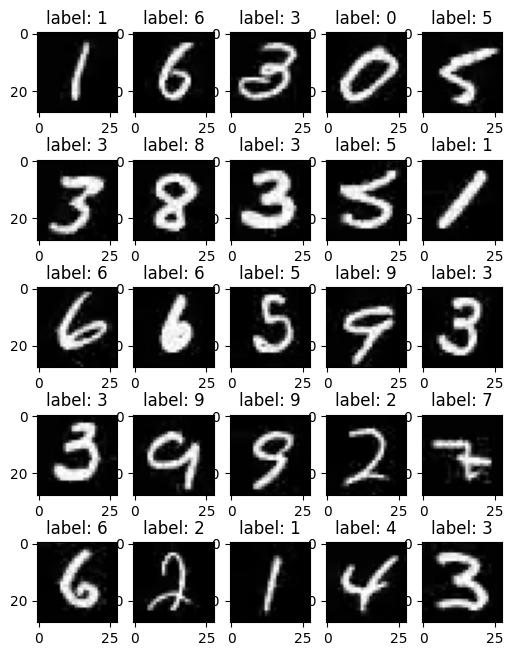

In [12]:
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=[6,8])

df = response.batch.frames
for axi in ax.flat:
    idx = np.random.randint(len(df))
    img = df['mnistvideo.data'].iloc[idx]
    label = df['mnistcnn.label'].iloc[idx]
    axi.imshow(img)
    
    axi.set_title(f'label: {label}')

plt.show()